# Wine Quality Data Set

The data was downloaded from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/wine+quality

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: <a href="https://www.vinhoverde.pt/en/">[Web Link]</a>  or the reference [Cortez et al., 2009]. 

In the above reference, two datasets were created, using red and white wine samples. The inputs include objective tests (e.g. PH values) and the output is based on sensory data (median of at least 3 evaluations made by wine experts). Each expert graded the wine quality between 0 (very bad) and 10 (very excellent). Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

## Goal

The objective is to classify the data into the various quality score categories. Three machine learning models will be trained and tested to determine which will yield the best results:

- Support Vector Machines (SVM)
- Decision Trees
- Random Forest

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [171]:
#Read the file. Data is separated by semicolons instead of commas
wine_red = pd.read_csv('winequality-red.csv',sep=';')
wine_white = pd.read_csv('winequality-white.csv',sep=';')

# Checking for Missing Values

In [172]:
#Checking the entire data frame for missing values
wine_red.isna().any().any()

False

In [173]:
#Checking the entire data frame for missing values
wine_white.isna().any().any()

False

There are no missing values in either dataset.

# Combining the Datasets

We are seeking to identify a machine learning model that will predict the quality of wine. It would be beneficial to train the model across all the wine data as the model will have more values to train on for each wine quality score.

## Creating a label for wine type
 
We will create a new column for "type"

- Red wine will be labelled as 0,
- White wine will be labelled as 1.

In [174]:
wine_red['type'] = 0
wine_white['type'] = 1

In [175]:
#Creating a new dataframe called wine that contains all the details of all wines
wine = pd.concat([wine_red, wine_white], axis=0)

In [176]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [177]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'type'],
      dtype='object')

In [178]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 710.6 KB


# Checking for Outliers

In [179]:
from scipy import stats
from scipy.stats import zscore

- Assuming the data has a gaussian distribution as there are many more normal wines than poor or excellent ones. 
- Outliers would be more than three standard deviations away. 

In [180]:
z_scores = stats.zscore(wine)

#Identifying points that are three standard deviations away
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

#Creating new datframe with with the filtered values
wine_new = wine[filtered_entries]

In [181]:
#Identifying number of rows in new dataframe with the filtered values
wine_new_rows = len(wine_new)

#Number of rows in the original dataframes
wine_rows = len(wine.index)

#Reduction in the rows of the dataset
wine_reduction = wine_rows-wine_new_rows
wine_reduction_percent = (wine_reduction/wine_rows)*100

print(wine_reduction,"outliers have been removed from the wine_red dataset, which represents", round(wine_reduction_percent,2),"% of the original dataset." )

508 outliers have been removed from the wine_red dataset, which represents 7.82 % of the original dataset.


As a significant number of outliers have been removed we need to check if any of the quality scores have been removed.

In [182]:
#Original number of wines corresponding to each quality rating
wine['quality'].value_counts().sort_index()

3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64

For wines with quality 3 and 9 there is insufficient data to accurately predict the quality using a machine learning model.

In [183]:
wine_new['quality'].value_counts().sort_index()

4     184
5    1958
6    2636
7    1027
8     184
Name: quality, dtype: int64

- Poor quality wines with a score of 3 have been removed.
- Excellent quality wines with a score of 9 have been removed.
- While wines of quality 4 and 8 are still present.

We will proceed with the new dataset with the filtered values.

# Exploratory Data Analysis 

In [184]:
wine_new.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
fixed acidity,1.000000,0.204046,0.242447,-0.090760,0.364424,-0.250571,-0.274014,0.407062,-0.221865,0.233203,-0.103256,-0.085213,-0.442849
volatile acidity,0.204046,1.000000,-0.430326,-0.197058,0.496519,-0.346565,-0.404227,0.247992,0.262876,0.224637,-0.039541,-0.242564,-0.655691
citric acid,0.242447,-0.430326,1.000000,0.165821,-0.136419,0.188659,0.259480,0.041760,-0.293830,-0.016885,-0.001722,0.082348,0.264488
residual sugar,-0.090760,-0.197058,0.165821,1.000000,-0.140055,0.436970,0.503755,0.583922,-0.279926,-0.169277,-0.389312,-0.043271,0.338436
chlorides,0.364424,0.496519,-0.136419,-0.140055,1.000000,-0.259136,-0.350782,0.484535,0.202127,0.325731,-0.318957,-0.249538,-0.684358
free sulfur dioxide,-0.250571,-0.346565,0.188659,0.436970,-0.259136,1.000000,0.718169,0.088629,-0.165620,-0.167453,-0.193071,0.070611,0.461297
total sulfur dioxide,-0.274014,-0.404227,0.259480,0.503755,-0.350782,0.718169,1.000000,0.098138,-0.259024,-0.255926,-0.288291,-0.046646,0.683218
density,0.407062,0.247992,0.041760,0.583922,0.484535,0.088629,0.098138,1.000000,0.051610,0.235882,-0.739544,-0.322905,-0.358738
pH,-0.221865,0.262876,-0.293830,-0.279926,0.202127,-0.165620,-0.259024,0.051610,1.000000,0.292439,0.091032,0.024722,-0.371684
sulphates,0.233203,0.224637,-0.016885,-0.169277,0.325731,-0.167453,-0.255926,0.235882,0.292439,1.000000,0.009271,0.051402,-0.464822


<AxesSubplot:>

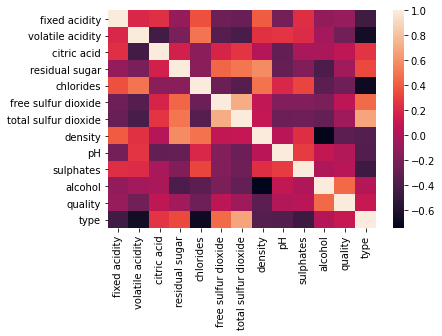

In [185]:
sns.heatmap(wine_new.corr())

It appears that free sulphur dioxide values appear to be most correlated with quality.

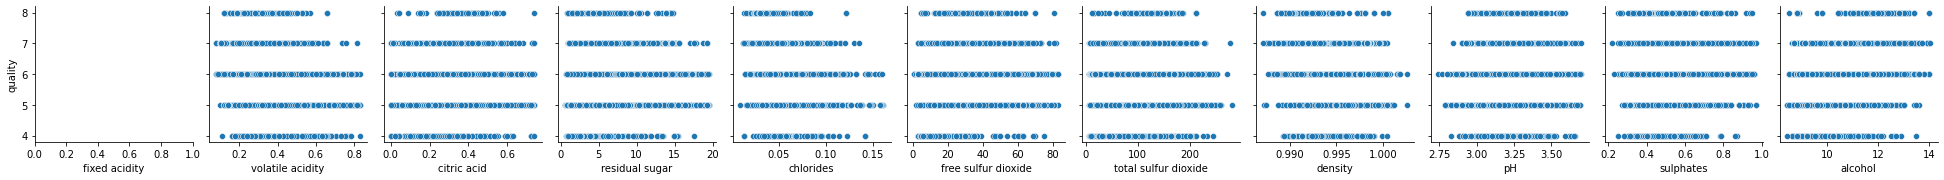

In [186]:
sns.pairplot(data=wine_new,
                  y_vars=['quality'],
                  x_vars=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'])

It is difficult to understand the relationship between variables based on the plots above. Specific domain knowledge may be necessary to understand how to visualize the data.

# Train and Test the Model

In this stage we will separate our dataset into training data that will be used to train the model and testing data that will be used to judge the accuracy of the results. We will now train and test the three machine learning models to determine which will yield the best results:

- Support Vector Machines (SVM)
- Decision Trees
- Random Forest

## Train Test Split

In [187]:
from sklearn.model_selection import train_test_split

In [188]:
X = wine_new.drop('quality',axis=1)
y = wine_new['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

## Support Vector Machines (SVM)

### Train the Support Vector Classifier

In [189]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train,y_train)

SVC()

### Support Vector Machines: Predictions and Evaluations

In [190]:
predictions = model.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           4       0.00      0.00      0.00        59
           5       0.41      0.07      0.12       581
           6       0.44      0.94      0.60       801
           7       0.00      0.00      0.00       302
           8       0.00      0.00      0.00        54

    accuracy                           0.44      1797
   macro avg       0.17      0.20      0.15      1797
weighted avg       0.33      0.44      0.31      1797



C:\Users\Priank Ravichandar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- We see above that the accuracy is only at <b>0.45</b>. 
- It is only able to predict quality for wines with quality scores of 5 and 6.

We may be able to improve the performance using Gridsearch.

### Gridsearch

GridSearchCV takes a dictionary that describes the parameters that should be tried and a model to train. The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested.

In [191]:
#Import GridsearchCV from SciKit Learn
from sklearn.model_selection import GridSearchCV

#Creating a dictionary called param_grid and fill out some parameters for C and gamma
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 

#Create a GridSearchCV object and fit it to the training data
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... C=0.1, gamma=1, total=   1.1s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] ................................... C=0.1, gamma=1, total=   1.1s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   1.1s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   1.1s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   1.2s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.8s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.8s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.8s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .

[CV] ................................ C=10, gamma=0.001, total=   0.5s
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total=   1.1s
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total=   1.1s
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total=   1.1s
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total=   1.1s
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total=   1.1s
[CV] C=100, gamma=0.1 ................................................
[CV] ................................. C=100, gamma=0.1, total=   0.9s
[CV] C=100, gamma=0.1 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.0min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             verbose=2)

### Support Vector Machines: Predictions using Gridsearch

In [192]:
# Taking the grid model and create some predictions using the test set and create classification reports and confusion matrices for them
svm_grid_predictions = grid.predict(X_test)

print(classification_report(y_test,svm_grid_predictions))

              precision    recall  f1-score   support

           4       1.00      0.10      0.18        59
           5       0.84      0.34      0.49       581
           6       0.53      0.95      0.68       801
           7       0.88      0.30      0.45       302
           8       1.00      0.28      0.43        54

    accuracy                           0.60      1797
   macro avg       0.85      0.40      0.45      1797
weighted avg       0.72      0.60      0.56      1797



Using Gridsearch, Accuracy, Precision, Recall and F1-score have increased.
 
The model is now able to predict quality for all wines from quality score 4-8.

## Decision Trees

### Training a Decision Tree Model

In [193]:
#Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

In [194]:
#Create an instance of DecisionTreeClassifier() called dtree and fit it to the training data.
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

### Decision Tree: Predictions and Evaluation

In [195]:
decision_trees_predictions = dtree.predict(X_test)

print(classification_report(y_test,decision_trees_predictions))

              precision    recall  f1-score   support

           4       0.25      0.22      0.24        59
           5       0.64      0.62      0.63       581
           6       0.65      0.63      0.64       801
           7       0.51      0.60      0.55       302
           8       0.35      0.33      0.34        54

    accuracy                           0.60      1797
   macro avg       0.48      0.48      0.48      1797
weighted avg       0.60      0.60      0.60      1797



Accuracy, Precision, Recall and F1-Score, are higher than SVM.

## Random Forests

### Training the Random Forest Model

In [196]:
#Create an instance of the RandomForestClassifier class and fit it to our training data
from sklearn.ensemble import RandomForestClassifier

#n_estimators is the number of trees in the forest
rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(X_train,y_train)

RandomForestClassifier()

### Random Forests: Predictions and Evaluation

In [197]:
random_forests_predictions = rfc.predict(X_test)

print(classification_report(y_test,random_forests_predictions))

              precision    recall  f1-score   support

           4       1.00      0.14      0.24        59
           5       0.71      0.69      0.70       581
           6       0.65      0.78      0.71       801
           7       0.73      0.57      0.64       302
           8       0.89      0.31      0.47        54

    accuracy                           0.68      1797
   macro avg       0.80      0.50      0.55      1797
weighted avg       0.70      0.68      0.67      1797



# Comparing the Models

In [198]:
#Converting each of the classification reports into dictionaries

report_svm = classification_report(y_test,svm_grid_predictions , output_dict=True)
report_dt = classification_report(y_test,decision_trees_predictions , output_dict=True)
report_rf = classification_report(y_test,random_forests_predictions , output_dict=True)

In [199]:
model = {'Model Name':['SVM', 'Decision Trees', 'Random Forests'],
        'Accuracy':[report_svm['accuracy'],report_dt['accuracy'],report_rf['accuracy']],
        'Precision':[report_svm['weighted avg']['precision'],report_dt['weighted avg']['precision'],report_rf['weighted avg']['precision']],
        'Recall':[report_svm['weighted avg']['recall'],report_dt['weighted avg']['recall'],report_rf['weighted avg']['recall']],
        'F1-Score':[report_svm['weighted avg']['f1-score'],report_dt['weighted avg']['f1-score'],report_rf['weighted avg']['f1-score']]}

model = pd.DataFrame(model)

model.round(2).sort_values(by=['Accuracy'],ascending=False)

,Model Name,Accuracy,Precision,Recall,F1-Score
2,Random Forests,0.68,0.70,0.68,0.67
0,SVM,0.60,0.72,0.60,0.56
1,Decision Trees,0.60,0.60,0.60,0.60


- Overall, the <b>Random Forests </b>model performed the best. 
- The SVM model had the highest precision but did not fare as well in other categories.

We can now test the Random Forest model againsts the following data sets to see how well it performs
- Filtered Wine Dataset
- Original Wine Dataset
- Red Wine Dataset
- White Wine Dataset

<u>Note:</u> As the model is only trained to predict the quality score of wines with a score of 4-8, we will have to drop rows with wines with a quality score of 3 and 9.

# Testing the Model 

## Random Forests: Filtered Wine Dataset

In [200]:
#Selecting a random sample of 100 wines
rand_wine = wine_new.sample(n=100)

X = rand_wine.drop('quality',axis=1)
y = rand_wine['quality']

#Random Forests predictions
random_forests_predictions = rfc.predict(X)

#Assigning the classification report to a dictionary to call later
c1 = classification_report(y,random_forests_predictions, output_dict=True)

print(classification_report(y,random_forests_predictions))

              precision    recall  f1-score   support

           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00        32
           6       0.96      1.00      0.98        47
           7       0.94      0.88      0.91        17
           8       1.00      0.67      0.80         3

    accuracy                           0.97       100
   macro avg       0.98      0.91      0.94       100
weighted avg       0.97      0.97      0.97       100



## Random Forests: Original Wine Dataset

In [201]:
#Selecting a random sample of 100 wines where quality is between 4 and 8
rand_wine = wine[wine['quality'].isin([4,5,6,7,8])].sample(n=100)

X = rand_wine.drop('quality',axis=1)
y = rand_wine['quality']

#Random Forests predictions
random_forests_predictions = rfc.predict(X)

#Assigning the classification report to a dictionary to call later
c2 = classification_report(y,random_forests_predictions, output_dict=True)

print(classification_report(y,random_forests_predictions))

              precision    recall  f1-score   support

           4       1.00      0.43      0.60         7
           5       0.90      0.96      0.93        27
           6       0.83      0.93      0.87        41
           7       0.90      0.86      0.88        22
           8       1.00      0.33      0.50         3

    accuracy                           0.87       100
   macro avg       0.93      0.70      0.76       100
weighted avg       0.88      0.87      0.86       100



## Random Forests: Red Wine Dataset

In [202]:
#Selecting a random sample of 100 wines where quality is between 4 and 8
rand_wine = wine_red[wine_red['quality'].isin([4,5,6,7,8])].sample(n=100)

X = rand_wine.drop('quality',axis=1)
y = rand_wine['quality']

#Random Forests predictions
random_forests_predictions = rfc.predict(X)

#Assigning the classification report to a dictionary to call later
c3 = classification_report(y,random_forests_predictions, output_dict=True)

print(classification_report(y,random_forests_predictions))

              precision    recall  f1-score   support

           4       1.00      0.50      0.67         2
           5       0.94      0.83      0.88        41
           6       0.85      0.91      0.88        44
           7       0.73      0.92      0.81        12
           8       1.00      1.00      1.00         1

    accuracy                           0.87       100
   macro avg       0.91      0.83      0.85       100
weighted avg       0.88      0.87      0.87       100



## Random Forests: White Wine Dataset

In [203]:
#Selecting a random sample of 100 wines where quality is between 4 and 8
rand_wine = wine_white[wine_white['quality'].isin([4,5,6,7,8])].sample(n=100)

X = rand_wine.drop('quality',axis=1)
y = rand_wine['quality']

#Random Forests predictions
random_forests_predictions = rfc.predict(X)

#Assigning the classification report to a dictionary to call later
c4 = classification_report(y,random_forests_predictions, output_dict=True)

print(classification_report(y,random_forests_predictions))

              precision    recall  f1-score   support

           4       1.00      0.25      0.40         4
           5       0.89      0.86      0.87        28
           6       0.84      0.92      0.88        39
           7       0.92      0.92      0.92        24
           8       1.00      1.00      1.00         5

    accuracy                           0.88       100
   macro avg       0.93      0.79      0.81       100
weighted avg       0.89      0.88      0.87       100



## Comparing Performance

In [204]:
model = {'DataSet':['Filtered Wine Dataset', 'Original Wine Dataset', 'Red Wine Dataset','White Wine Dataset'],
        'Accuracy':[c1['accuracy'],c2['accuracy'],c3['accuracy'],c4['accuracy']],
        'Precision':[c1['weighted avg']['precision'],c2['weighted avg']['precision'],c3['weighted avg']['precision'],c4['weighted avg']['precision']],
        'Recall':[c1['weighted avg']['recall'],c2['weighted avg']['recall'],c3['weighted avg']['recall'],c4['weighted avg']['recall']],
        'F1-Score':[c1['weighted avg']['f1-score'],c2['weighted avg']['f1-score'],c3['weighted avg']['f1-score'],c4['weighted avg']['f1-score']]}

model = pd.DataFrame(model)

model.round(2).sort_values(by=['Accuracy'],ascending=False)

,DataSet,Accuracy,Precision,Recall,F1-Score
0,Filtered Wine Dataset,0.97,0.97,0.97,0.97
3,White Wine Dataset,0.88,0.89,0.88,0.87
1,Original Wine Dataset,0.87,0.88,0.87,0.86
2,Red Wine Dataset,0.87,0.88,0.87,0.87


Given a random sample of 100 wines from each dataset, the Random Forests model performed the best on the filtered wine dataset across all categories, which makes sense since it was trained on a subset of that data.

Although the model excludes wines with quality scores of 3 and 9, those wines can be considered outliers since there is insufficient data to accurately predict those quality scores using a machine learning model.

Overall, the Random Forests model does a good job of predicting wine quality, regardless of the type of wine.